In [3]:
from PIL import Image
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

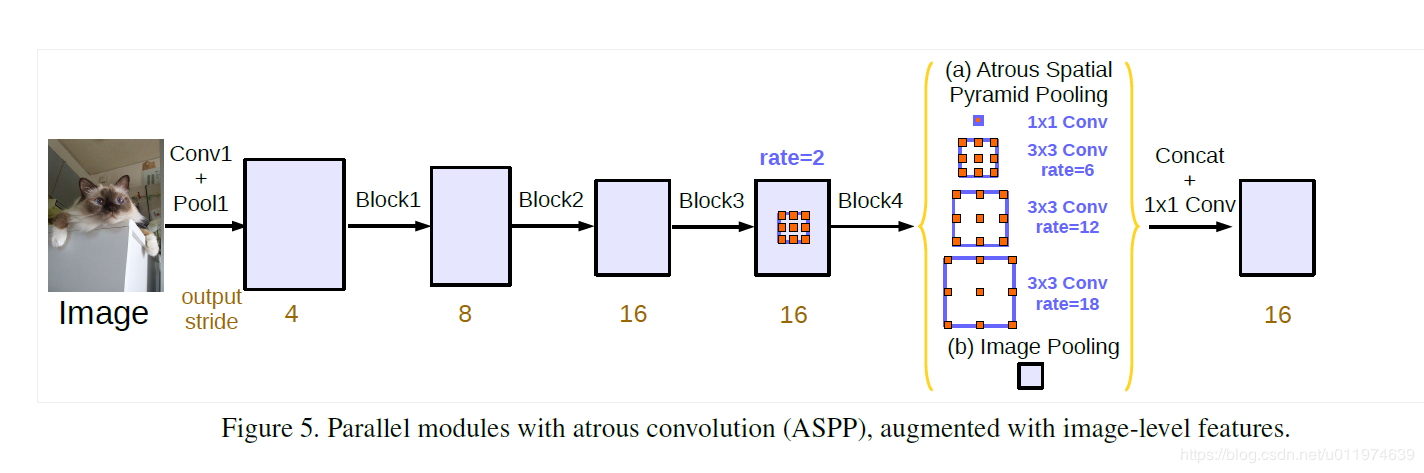

In [4]:
Image.open('/home/lsj/Music/deepv3_1.png')

In [5]:
class ASPP_module(nn.Module):
    def __init__(self, inplanes, planes, dilation):
        super(ASPP_module, self).__init__()
        if dilation == 1:
            kernel_size = 1
            padding = 0
        else:
            kernel_size = 3
            padding = dilation
        self.atrous_convolution = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                                            stride=1, padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_convolution(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

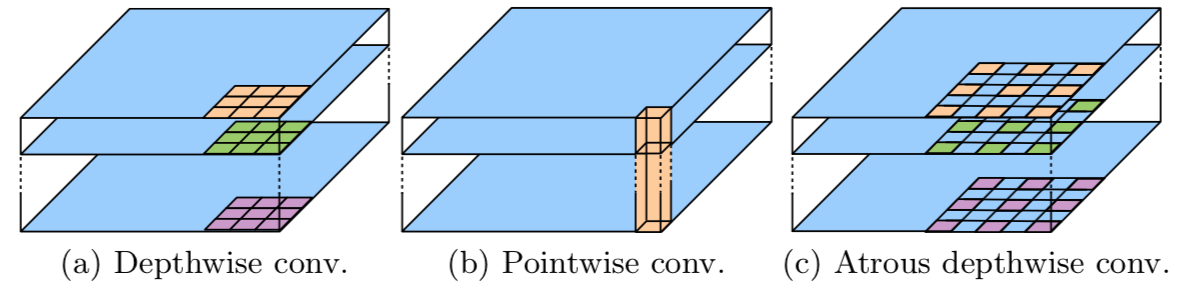

In [6]:
Image.open('/home/lsj/Music/deepv3_2.png')

In [7]:
def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class SeparableConv2d_same(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, dilation=1, bias=False):
        super(SeparableConv2d_same, self).__init__()

        self.conv1 = nn.Conv2d(inplanes, inplanes, kernel_size, stride, 0, dilation,
                               groups=inplanes, bias=bias)
        self.pointwise = nn.Conv2d(inplanes, planes, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = fixed_padding(x, self.conv1.kernel_size[0], dilation=self.conv1.dilation[0])
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


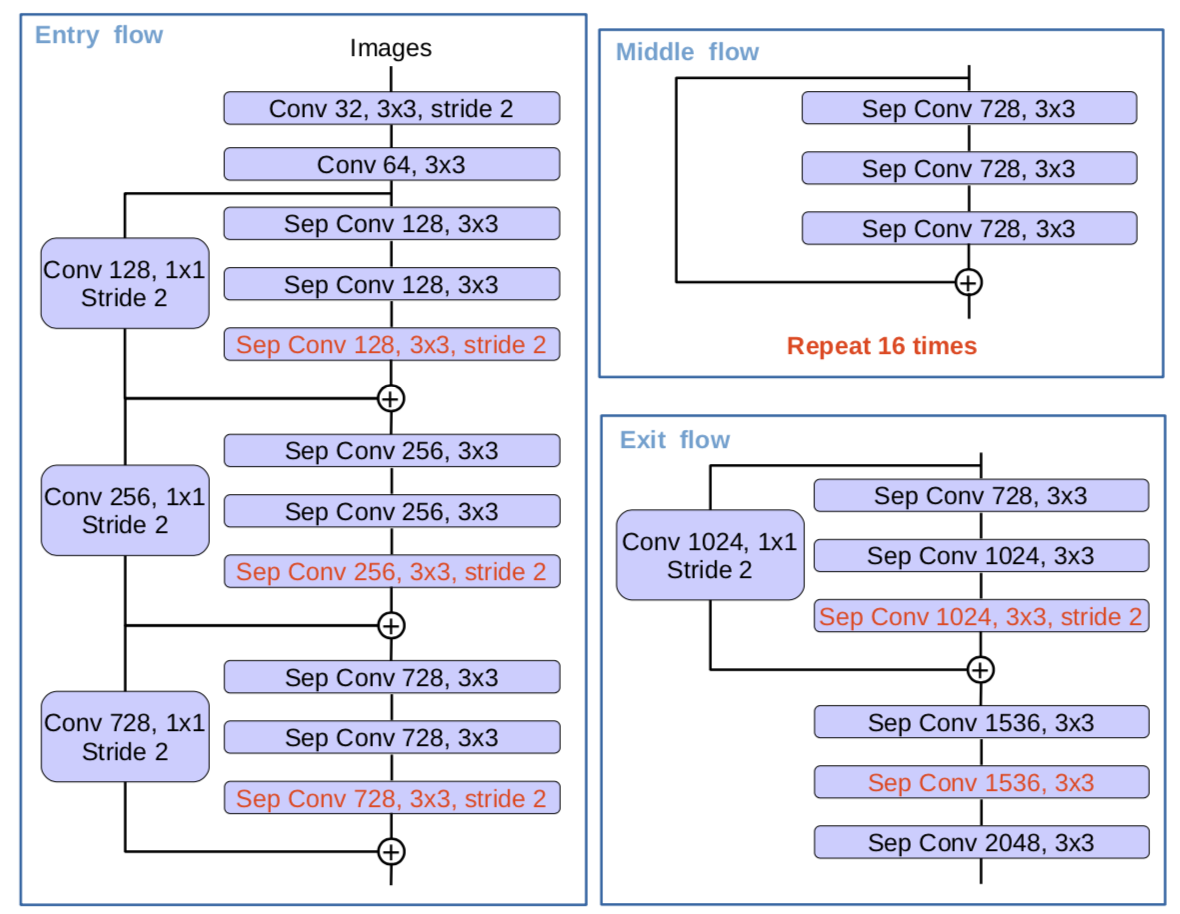

In [13]:
Image.open('/home/lsj/Music/deepv3_3.png')

In [12]:
class Block(nn.Module):
    def __init__(self, inplanes, planes, reps, stride=1, dilation=1, start_with_relu=True, grow_first=True, is_last=False):
        super(Block, self).__init__()

        if planes != inplanes or stride != 1:
            self.skip = nn.Conv2d(inplanes, planes, 1, stride=stride, bias=False)
            self.skipbn = nn.BatchNorm2d(planes)
        else:
            self.skip = None

        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = inplanes
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d_same(inplanes, planes, 3, stride=1, dilation=dilation))
            rep.append(nn.BatchNorm2d(planes))
            filters = planes

        for i in range(reps - 1):
            rep.append(self.relu)
            rep.append(SeparableConv2d_same(filters, filters, 3, stride=1, dilation=dilation))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d_same(inplanes, planes, 3, stride=1, dilation=dilation))
            rep.append(nn.BatchNorm2d(planes))

        if not start_with_relu:
            rep = rep[1:]

        if stride != 1:
            rep.append(SeparableConv2d_same(planes, planes, 3, stride=2))

        if stride == 1 and is_last:
            rep.append(SeparableConv2d_same(planes, planes, 3, stride=1))

        self.rep = nn.Sequential(*rep)

    def forward(self, inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x += skip

        return x


class Xception(nn.Module):
    """
    Modified Alighed Xception
    """
    def __init__(self, inplanes=3, os=16):
        super(Xception, self).__init__()

        if os == 16:
            entry_block3_stride = 2
            middle_block_dilation = 1
            exit_block_dilations = (1, 2)
        elif os == 8:
            entry_block3_stride = 1
            middle_block_dilation = 2
            exit_block_dilations = (2, 4)
        else:
            raise NotImplementedError


        # Entry flow
        self.conv1 = nn.Conv2d(inplanes, 32, 3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        self.block1 = Block(64, 128, reps=2, stride=2, start_with_relu=False)
        self.block2 = Block(128, 256, reps=2, stride=2, start_with_relu=True)
        self.block3 = Block(256, 728, reps=2, stride=entry_block3_stride, start_with_relu=True)

        # Middle flow
        self.block4 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation)
        self.block5 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation)
        self.block6 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation)
        self.block7 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation)
        self.block8 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation)
        self.block9 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation)
        self.block10 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation)
        self.block11 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation)
        self.block12 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation)
        self.block13 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation)
        self.block14 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation)
        self.block15 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation)
        self.block16 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation)
        self.block17 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation)
        self.block18 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation)
        self.block19 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation)

        # Exit flow
        self.block20 = Block(728, 1024, reps=2, stride=1, dilation=exit_block_dilations[0],
                             start_with_relu=True, grow_first=False, is_last=True)

        self.conv3 = SeparableConv2d_same(1024, 1536, 3, stride=1, dilation=exit_block_dilations[1])
        self.bn3 = nn.BatchNorm2d(1536)

        self.conv4 = SeparableConv2d_same(1536, 1536, 3, stride=1, dilation=exit_block_dilations[1])
        self.bn4 = nn.BatchNorm2d(1536)

        self.conv5 = SeparableConv2d_same(1536, 2048, 3, stride=1, dilation=exit_block_dilations[1])
        self.bn5 = nn.BatchNorm2d(2048)

        # Init weights
        self._init_weight()

    def forward(self, x):
        # Entry flow
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.block1(x)
        low_level_feat = x
        x = self.block2(x)
        x = self.block3(x)

        # Middle flow
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        x = self.block13(x)
        x = self.block14(x)
        x = self.block15(x)
        x = self.block16(x)
        x = self.block17(x)
        x = self.block18(x)
        x = self.block19(x)

        # Exit flow
        x = self.block20(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)

        return x, low_level_feat

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

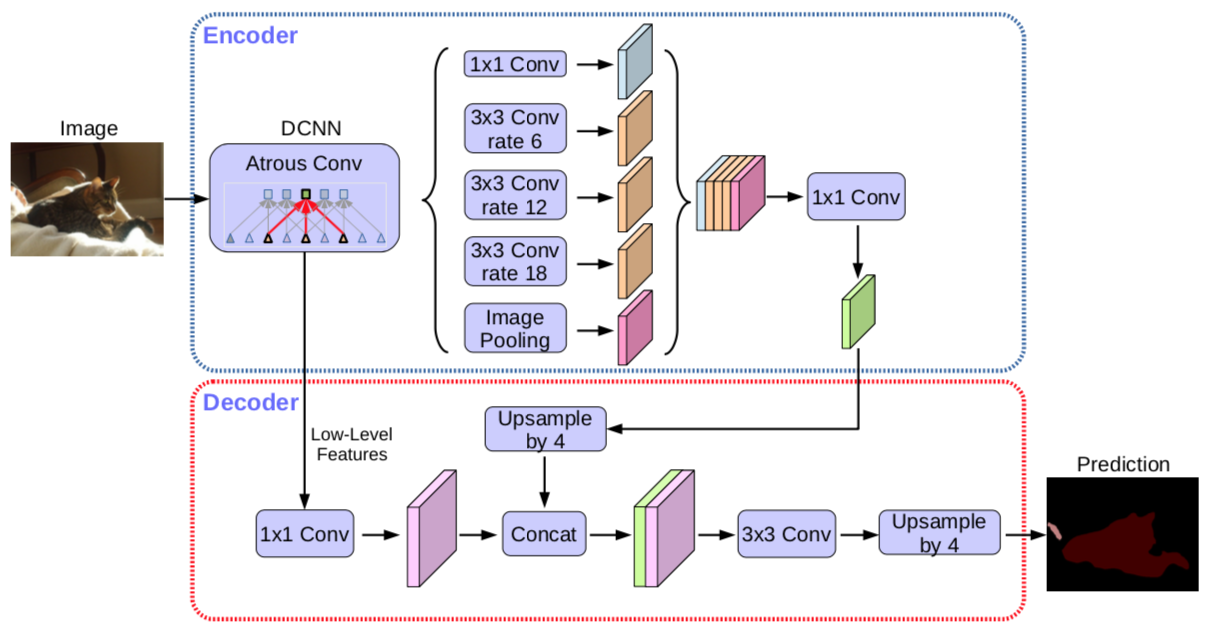

In [14]:
Image.open('/home/lsj/Music/deepv3_4.png')

In [15]:
class DeepLabv3_plus(nn.Module):
    def __init__(self, nInputChannels=3, n_classes=21, os=16, _print=True):
        if _print:
            print("Constructing DeepLabv3+ model...")
            print("Backbone: Xception")
            print("Number of classes: {}".format(n_classes))
            print("Output stride: {}".format(os))
            print("Number of Input Channels: {}".format(nInputChannels))
        super(DeepLabv3_plus, self).__init__()

        # Atrous Conv
        self.xception_features = Xception(nInputChannels, os)

        # ASPP
        if os == 16:
            dilations = [1, 6, 12, 18]
        elif os == 8:
            dilations = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        self.aspp1 = ASPP_module(2048, 256, dilation=dilations[0])
        self.aspp2 = ASPP_module(2048, 256, dilation=dilations[1])
        self.aspp3 = ASPP_module(2048, 256, dilation=dilations[2])
        self.aspp4 = ASPP_module(2048, 256, dilation=dilations[3])

        self.relu = nn.ReLU()

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(2048, 256, 1, stride=1, bias=False),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU())

        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)

        # adopt [1x1, 48] for channel reduction.
        self.conv2 = nn.Conv2d(128, 48, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(48)

        self.last_conv = nn.Sequential(nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(256, n_classes, kernel_size=1, stride=1))

    def forward(self, input):
        x, low_level_features = self.xception_features(input)
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = F.interpolate(x, size=(int(math.ceil(input.size()[-2]/4)),
                                int(math.ceil(input.size()[-1]/4))), mode='bilinear', align_corners=True)

        low_level_features = self.conv2(low_level_features)
        low_level_features = self.bn2(low_level_features)
        low_level_features = self.relu(low_level_features)

        x = torch.cat((x, low_level_features), dim=1)
        x = self.last_conv(x)
        x = F.interpolate(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [16]:
model = DeepLabv3_plus(nInputChannels=3, n_classes=21, os=16, _print=True)
model.eval()
image = torch.randn(1, 3, 512, 512)
output = model(image)
print(output.size())

Constructing DeepLabv3+ model...
Backbone: Xception
Number of classes: 21
Output stride: 16
Number of Input Channels: 3
torch.Size([1, 21, 512, 512])
